In [1]:
# Add py_package path to system PYTHONPATH file

from sys import path

from os.path import expanduser as expanduser
from os.path import join as join

py_path = expanduser("~") 
for p in ["Documents", "CallCenterStaffing", "DataScripts", "py_package"]:
    py_path = join(py_path, p)

if py_path not in path:
    path.append(py_path)

In [12]:
    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from importlib import reload

from py_package import db_conn as db
from py_package import utils as u

# reload(db)
reload(u)

conn_dict = { 
    "user"     : "szymonbocian",   \
    "password" : "",               \
    "host"     : "localhost",      \
    "port"     : "5432",           \
    "database" : "dwh_call_center"
}
db = db.DbConn(conn_dict)

sql_dict = {
    "restriction"  : "SELECT * FROM snap.consultant_skills_vw;",
    "rest_col"     : "SELECT column_name FROM INFORMATION_SCHEMA.columns WHERE table_schema = 'snap' AND table_name = 'consultant_skills_vw';",
    "forecast"     : "SELECT * FROM snap.service_date_hour_vw WHERE date_key IN (20190311,20190312,20190313,20190314,20190315,20190316,20190317);",
    "forecast_col" : "SELECT column_name FROM INFORMATION_SCHEMA.columns WHERE table_schema = 'snap' AND table_name = 'service_date_hour_vw';"
}

col = [t[0] for t in db.run_sql(sql_dict["rest_col"])]
rest_df = pd.DataFrame(db.run_sql(sql_dict["restriction"]), columns = col)

col = [t[0] for t in db.run_sql(sql_dict["forecast_col"])]
forecast_df = pd.DataFrame(db.run_sql(sql_dict["forecast"]), columns = col)

# rest_df.head(20)

In [13]:
forecast_df["key"]   = 1
forecast_df["shift"] = forecast_df.apply(lambda x: "1" if x.hour_key < 15 else "2", axis = 1)
forecast_df.head(1)

,service_name,service_key,date_value,date_key,hour_key,start_hour,end_hour,period_hour,avg_handle_time_sec,avg_handle_time_min,total_call,key,shift
0,Billing,2,2019-03-11,20190311,6,06:00,06:59,06:00 - 06:59,696,11,3,1,1


In [15]:
requirements_dict = {
    "key"                  : [1],    \
    "in_period"            : [60],   \
    "avg_handle_time"      : [180],  \
    "required_service_lvl" : [0.8],  \
    "trgt_answer_time"     : [20],   \
    "max_occup"            : [0.85], \
    "shrink"               : [0.3]
}

required_df = pd.DataFrame.from_dict(requirements_dict)

df = pd.merge(forecast_df, required_df, on = "key")
df.head(10)

f = lambda x: u.calculate(x["total_call"],            
                          x["in_period"],            
#                           x["avg_handle_time_sec"],
                          x["avg_handle_time"],
                          x["required_service_lvl"], 
                          x["trgt_answer_time"],      
                          x["max_occup"],            
                          x["shrink"])

df["erlang_c"] = df.apply(f, axis = 1)

df[["probability_call_wait", 
    "acquired_service_level", 
    "immediately_answer_calls", 
    "max_occupancy", 
    "average_speed_of_answer", 
    "required_consultant_amount"]] = pd.DataFrame(df.erlang_c.values.tolist(), index = df.index)

df[["date_value", 
    "service_name",
    "period_hour", 
    "shift", 
    "total_call", 
    "required_consultant_amount",
    "probability_call_wait", 
    "acquired_service_level", 
    "immediately_answer_calls", 
    "max_occupancy", 
    "average_speed_of_answer"]].head(1)

,date_value,service_name,period_hour,shift,total_call,required_consultant_amount,probability_call_wait,acquired_service_level,immediately_answer_calls,max_occupancy,average_speed_of_answer
0,2019-03-11,Billing,06:00 - 06:59,1,3,3,1.05,99.15,98.95,7.5,1.02


In [16]:
df.groupby(["date_value", "service_name", "shift"]) \
    ["required_consultant_amount", "total_call"].sum().head(20)

required_consultant_amount  \
date_value service_name           shift                               
2019-03-11 Billing                1                              42   
                                  2                              12   
           Complaint              1                              42   
                                  2                              12   
           Contract extension     1                              40   
                                  2                              12   
           Delivery               1                              43   
                                  2                              12   
           Order                  1                              39   
                                  2                              12   
           Reclamation            1                              46   
                                  2                               6   
           Reservation            1                              39   
                                  2                              12   
           Reset account settings 1                              44   
                                  2                              12   
           Reset password         1                              45   
                                  2                              12   
           Tariff change          1                              43   
                                  2                               9   

                                         total_call  
date_value service_name           shift              
2019-03-11 Billing                1             203  
                                  2              15  
           Complaint              1             201  
                                  2              18  
           Contract extension     1             195  
                                  2              13  
           Delivery               1             216  
                                  2              11  
           Order                  1             187  
                                  2              10  
           Reclamation            1             220  
                                  2              11  
           Reservation            1             189  
                                  2              12  
           Reset account settings 1             219  
                                  2              11  
           Reset password         1             202  
                                  2              10  
           Tariff change          1             222  
                                  2              15

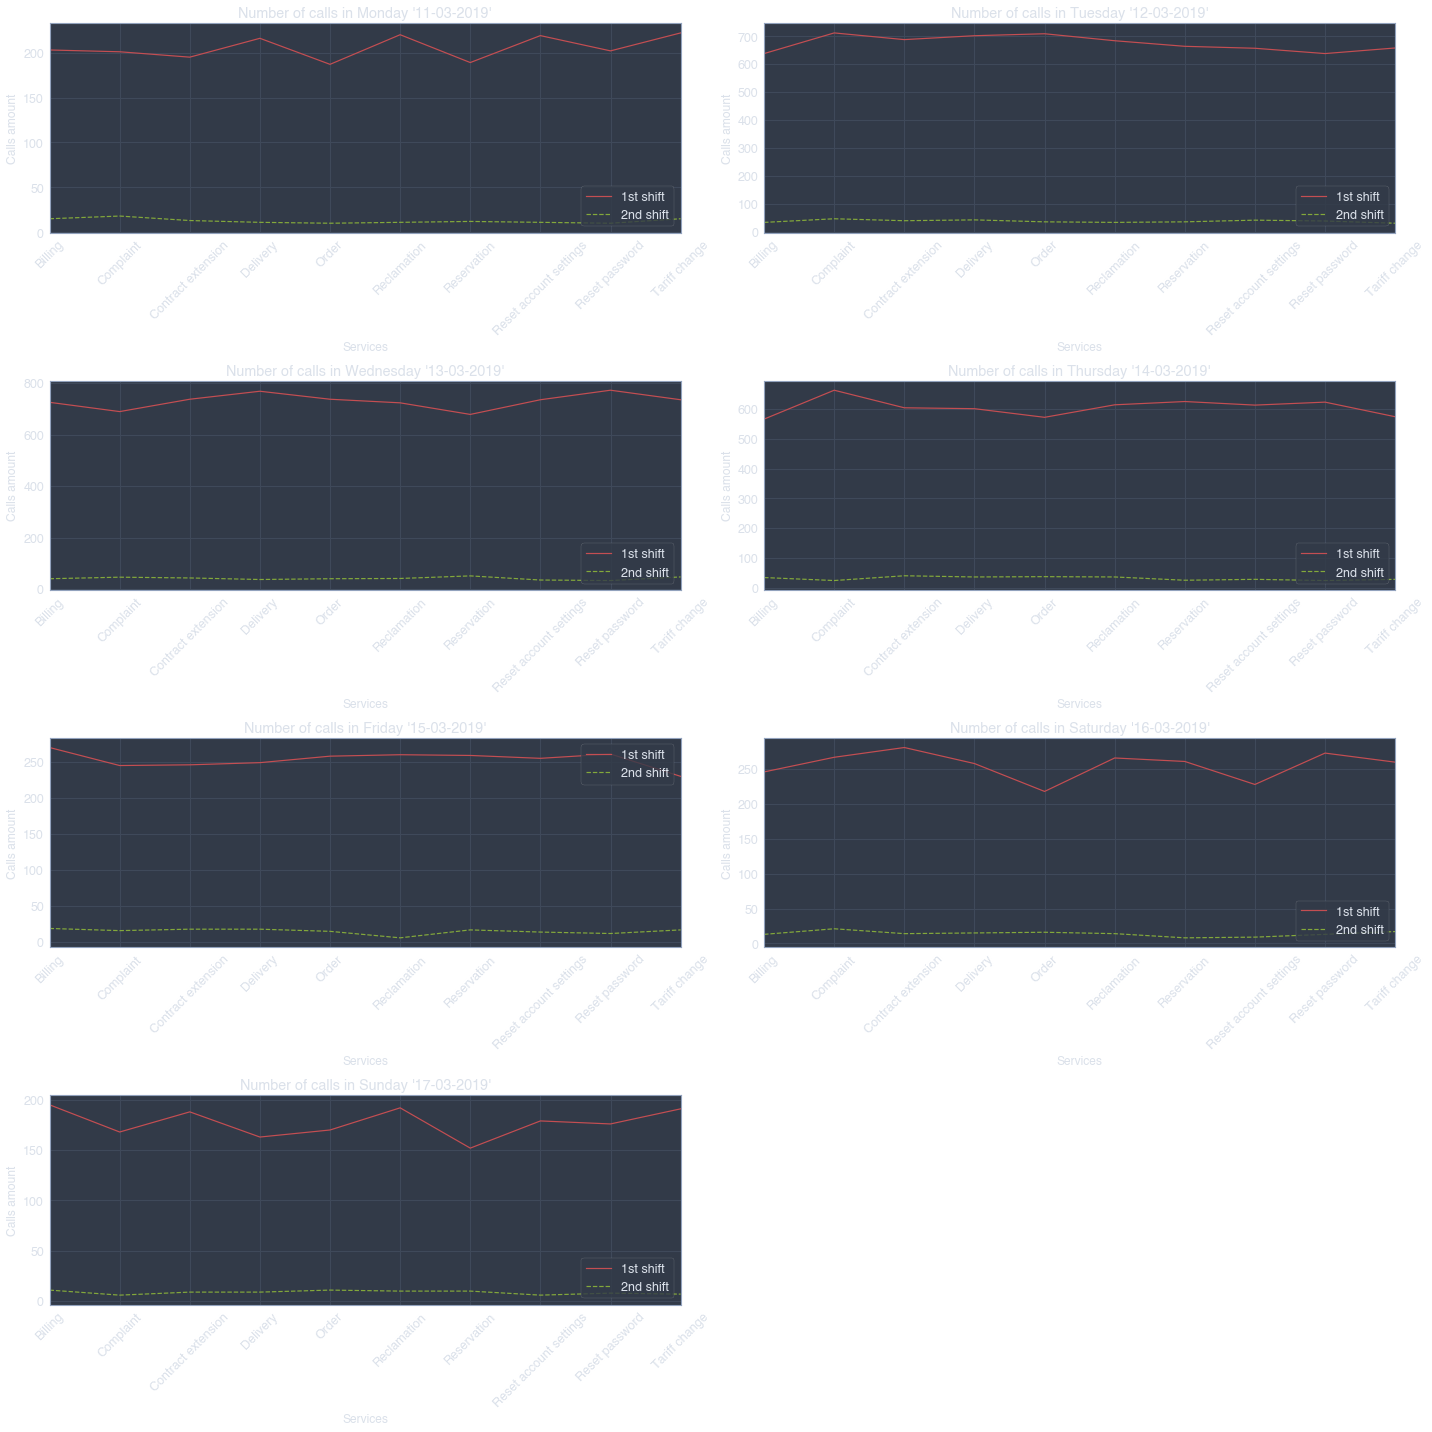

In [18]:
mon_1_df = df[(df["shift"] == "1") & (df["date_key"] == 20190311)].groupby(["service_name"])["total_call"].sum()
mon_2_df = df[(df["shift"] == "2") & (df["date_key"] == 20190311)].groupby(["service_name"])["total_call"].sum()

tue_1_df = df[(df["shift"] == "1") & (df["date_key"] == 20190312)].groupby(["service_name"])["total_call"].sum()
tue_2_df = df[(df["shift"] == "2") & (df["date_key"] == 20190312)].groupby(["service_name"])["total_call"].sum()

wed_1_df = df[(df["shift"] == "1") & (df["date_key"] == 20190313)].groupby(["service_name"])["total_call"].sum()
wed_2_df = df[(df["shift"] == "2") & (df["date_key"] == 20190313)].groupby(["service_name"])["total_call"].sum()

thu_1_df = df[(df["shift"] == "1") & (df["date_key"] == 20190314)].groupby(["service_name"])["total_call"].sum()
thu_2_df = df[(df["shift"] == "2") & (df["date_key"] == 20190314)].groupby(["service_name"])["total_call"].sum()

fri_1_df = df[(df["shift"] == "1") & (df["date_key"] == 20190315)].groupby(["service_name"])["total_call"].sum()
fri_2_df = df[(df["shift"] == "2") & (df["date_key"] == 20190315)].groupby(["service_name"])["total_call"].sum()

sat_1_df = df[(df["shift"] == "1") & (df["date_key"] == 20190316)].groupby(["service_name"])["total_call"].sum()
sat_2_df = df[(df["shift"] == "2") & (df["date_key"] == 20190316)].groupby(["service_name"])["total_call"].sum()

sun_1_df = df[(df["shift"] == "1") & (df["date_key"] == 20190317)].groupby(["service_name"])["total_call"].sum()
sun_2_df = df[(df["shift"] == "2") & (df["date_key"] == 20190317)].groupby(["service_name"])["total_call"].sum()

mo_ax = plt.subplot(421, title = "Number of calls in Monday '11-03-2019'")
mon_1_df.plot(figsize = (20,20), color = "r", ls = "-", label = "1st shift")
mon_2_df.plot(figsize = (20,20), color = "g", ls = "--", label = "2nd shift")
mo_ax.legend(loc = "lower right")
plt.xticks(rotation = 45)
mo_ax.set_xlabel("Services", fontsize = 12)
mo_ax.set_ylabel("Calls amount", fontsize = 12)

tu_ax = plt.subplot(422, title = "Number of calls in Tuesday '12-03-2019'")
tue_1_df.plot(figsize = (20,20), color = "r", ls = "-", label = "1st shift")
tue_2_df.plot(figsize = (20,20), color = "g", ls = "--", label = "2nd shift")
tu_ax.legend(loc = "lower right")
plt.xticks(rotation = 45)
tu_ax.set_xlabel("Services", fontsize = 12)
tu_ax.set_ylabel("Calls amount", fontsize = 12)

we_ax = plt.subplot(423, title = "Number of calls in Wednesday '13-03-2019'")
wed_1_df.plot(figsize = (20,20), color = "r", ls = "-", label = "1st shift")
wed_2_df.plot(figsize = (20,20), color = "g", ls = "--", label = "2nd shift")
we_ax.legend(loc = "lower right")
plt.xticks(rotation = 45)
we_ax.set_xlabel("Services", fontsize = 12)
we_ax.set_ylabel("Calls amount", fontsize = 12)

th_ax = plt.subplot(424, title = "Number of calls in Thursday '14-03-2019'")
thu_1_df.plot(figsize = (20,20), color = "r", ls = "-", label = "1st shift")
thu_2_df.plot(figsize = (20,20), color = "g", ls = "--", label = "2nd shift")
th_ax.legend(loc = "lower right")
plt.xticks(rotation = 45)
th_ax.set_xlabel("Services", fontsize = 12)
th_ax.set_ylabel("Calls amount", fontsize = 12)

fr_ax = plt.subplot(425, title = "Number of calls in Friday '15-03-2019'")
fri_1_df.plot(figsize = (20,20), color = "r", ls = "-", label = "1st shift")
fri_2_df.plot(figsize = (20,20), color = "g", ls = "--", label = "2nd shift")
fr_ax.legend(loc = "upper right")
plt.xticks(rotation = 45)
fr_ax.set_xlabel("Services", fontsize = 12)
fr_ax.set_ylabel("Calls amount", fontsize = 12)

sa_ax = plt.subplot(426, title = "Number of calls in Saturday '16-03-2019'")
sat_1_df.plot(figsize = (20,20), color = "r", ls = "-", label = "1st shift")
sat_2_df.plot(figsize = (20,20), color = "g", ls = "--", label = "2nd shift")
sa_ax.legend(loc = "lower right")
plt.xticks(rotation = 45)
sa_ax.set_xlabel("Services", fontsize = 12)
sa_ax.set_ylabel("Calls amount", fontsize = 12)

su_ax = plt.subplot(427, title = "Number of calls in Sunday '17-03-2019'")
sun_1_df.plot(figsize = (20,20), color = "r", ls = "-", label = "1st shift")
sun_2_df.plot(figsize = (20,20), color = "g", ls = "--", label = "2nd shift")
su_ax.legend(loc = "lower right")
plt.xticks(rotation = 45)
su_ax.set_xlabel("Services", fontsize = 12)
su_ax.set_ylabel("Calls amount", fontsize = 12)

plt.tight_layout()
plt.show()

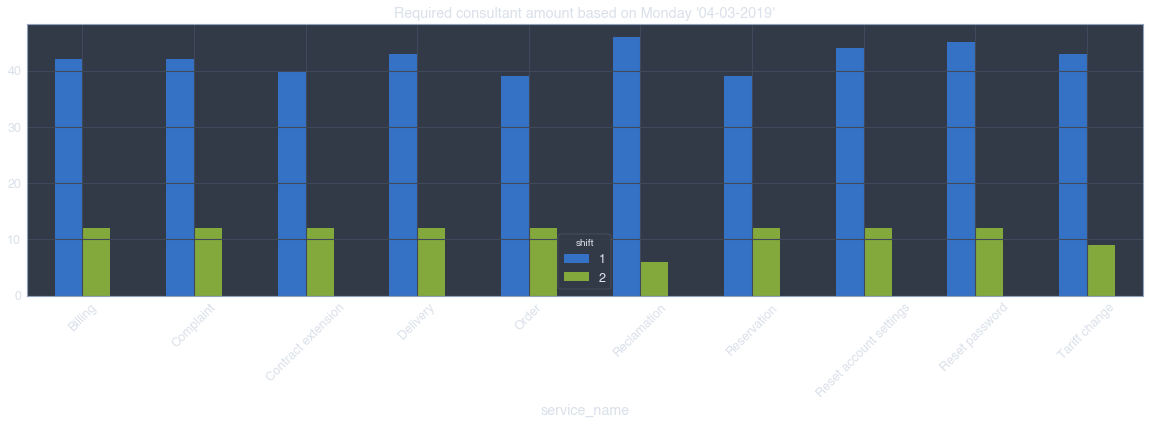

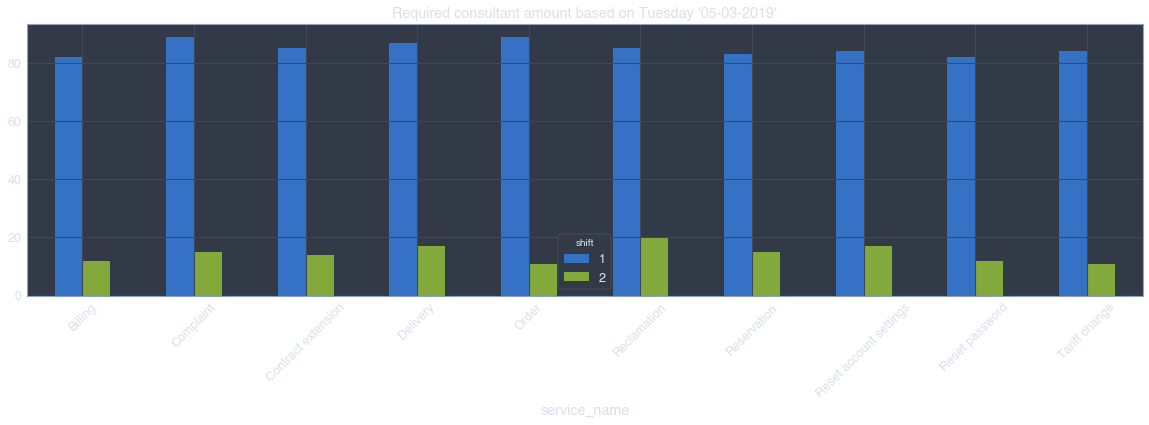

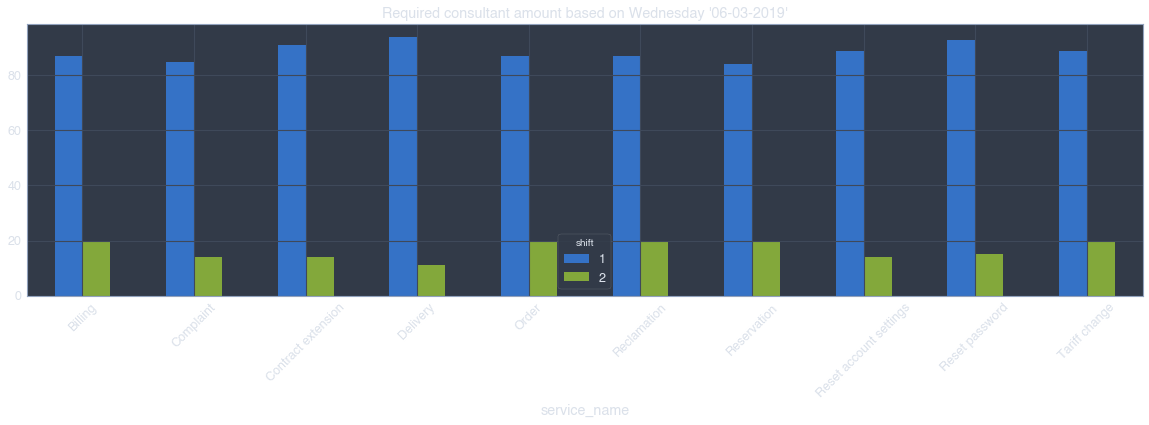

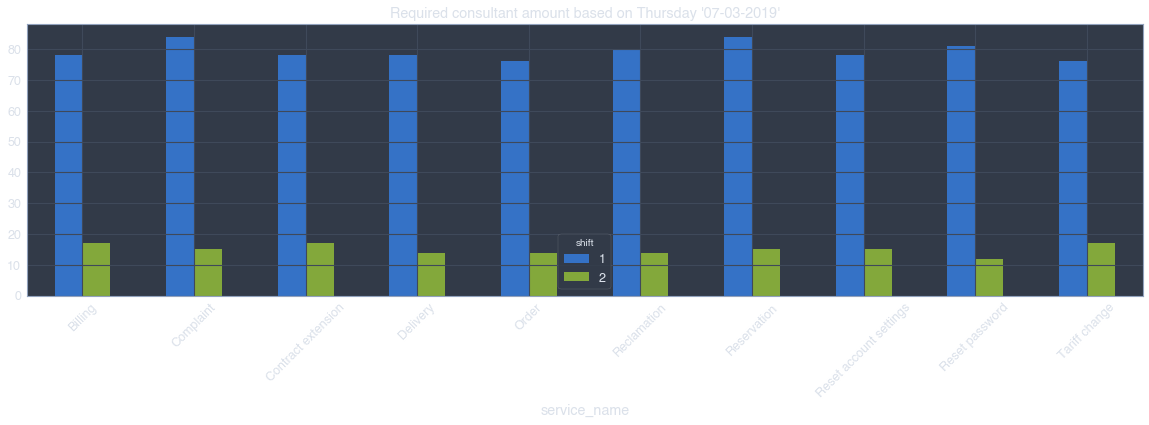

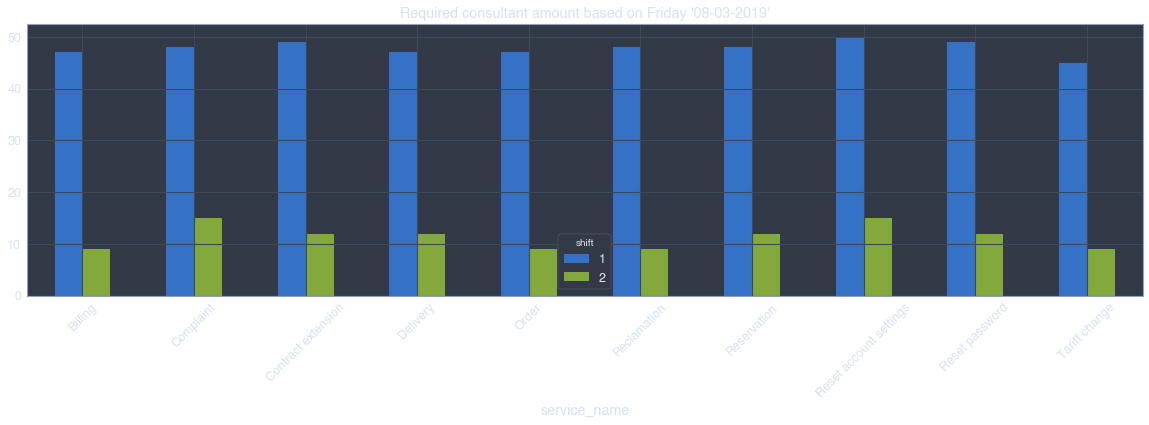

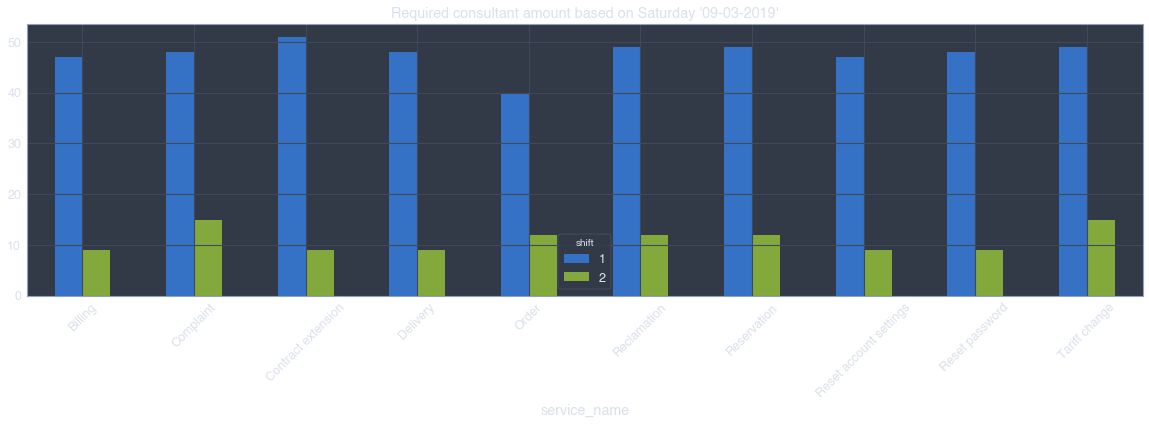

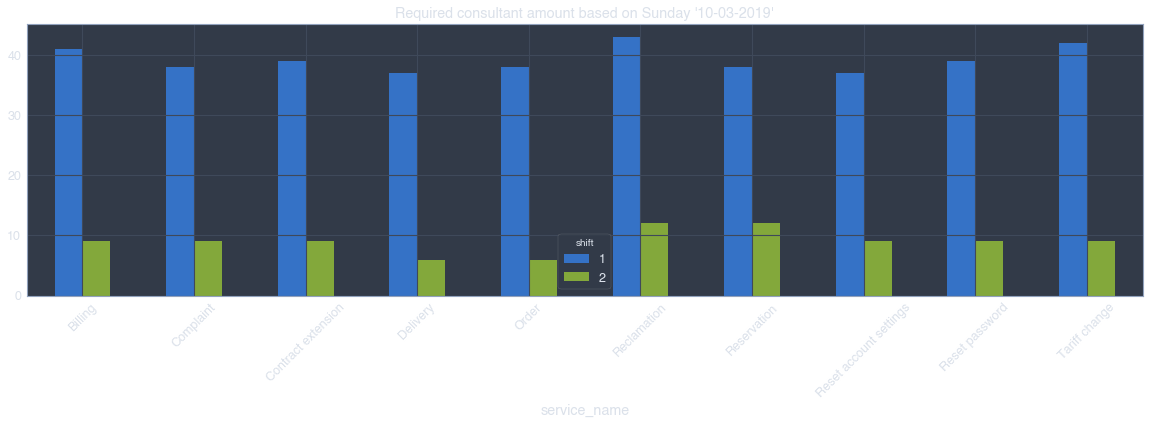

In [20]:
df[(df["date_key"] == 20190311)].groupby(["service_name", "shift"])["required_consultant_amount"].sum().unstack() \
    .plot.bar(rot = 45, title = "Required consultant amount based on Monday '04-03-2019'", figsize = (20,5), align = "center")

df[(df["date_key"] == 20190312)].groupby(["service_name", "shift"])["required_consultant_amount"].sum().unstack() \
    .plot.bar(rot = 45, title = "Required consultant amount based on Tuesday '05-03-2019'", figsize = (20,5), align = "center")

df[(df["date_key"] == 20190313)].groupby(["service_name", "shift"])["required_consultant_amount"].sum().unstack() \
    .plot.bar(rot = 45, title = "Required consultant amount based on Wednesday '06-03-2019'", figsize = (20,5), align = "center")

df[(df["date_key"] == 20190314)].groupby(["service_name", "shift"])["required_consultant_amount"].sum().unstack() \
    .plot.bar(rot = 45, title = "Required consultant amount based on Thursday '07-03-2019'", figsize = (20,5), align = "center")

df[(df["date_key"] == 20190315)].groupby(["service_name", "shift"])["required_consultant_amount"].sum().unstack() \
    .plot.bar(rot = 45, title = "Required consultant amount based on Friday '08-03-2019'", figsize = (20,5), align = "center")

df[(df["date_key"] == 20190316)].groupby(["service_name", "shift"])["required_consultant_amount"].sum().unstack() \
    .plot.bar(rot = 45, title = "Required consultant amount based on Saturday '09-03-2019'", figsize = (20,5), align = "center")

df[(df["date_key"] == 20190317)].groupby(["service_name", "shift"])["required_consultant_amount"].sum().unstack() \
    .plot.bar(rot = 45, title = "Required consultant amount based on Sunday '10-03-2019'", figsize = (20,5), align = "center")

plt.show()


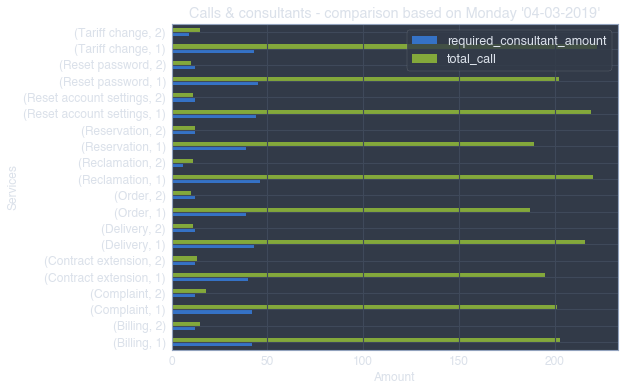

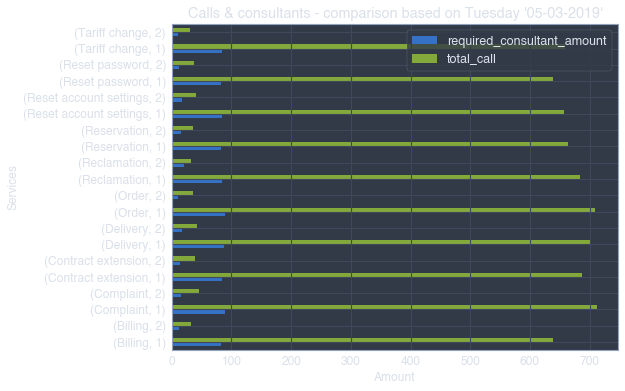

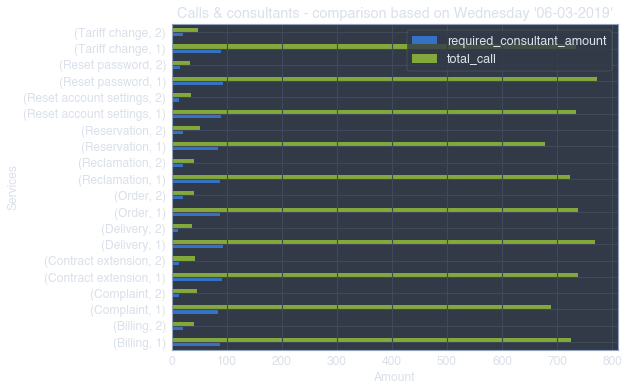

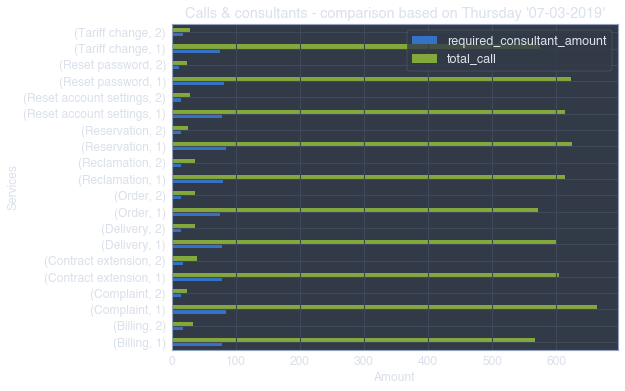

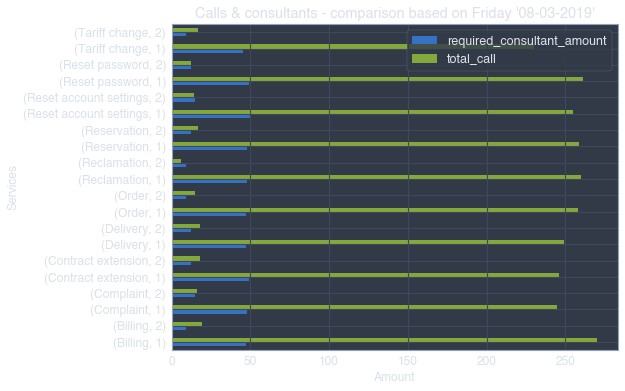

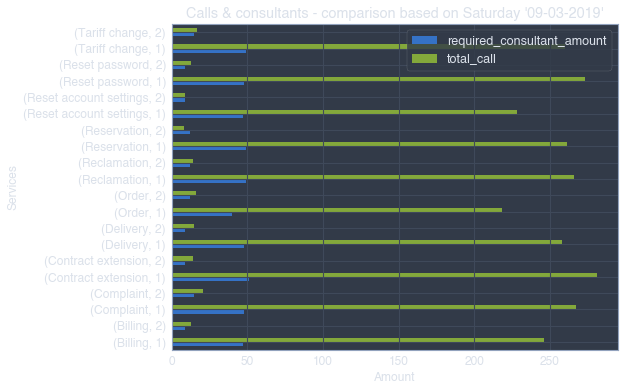

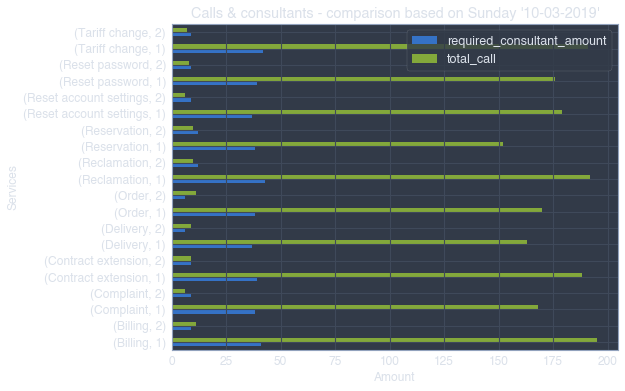

In [21]:

mo_ax = df[(df["date_key"] == 20190311)].groupby(["service_name", "shift"])["required_consultant_amount", "total_call"].sum()
tu_ax = df[(df["date_key"] == 20190312)].groupby(["service_name", "shift"])["required_consultant_amount", "total_call"].sum()
we_ax = df[(df["date_key"] == 20190313)].groupby(["service_name", "shift"])["required_consultant_amount", "total_call"].sum()
th_ax = df[(df["date_key"] == 20190314)].groupby(["service_name", "shift"])["required_consultant_amount", "total_call"].sum()
fr_ax = df[(df["date_key"] == 20190315)].groupby(["service_name", "shift"])["required_consultant_amount", "total_call"].sum()
sa_ax = df[(df["date_key"] == 20190316)].groupby(["service_name", "shift"])["required_consultant_amount", "total_call"].sum()
su_ax = df[(df["date_key"] == 20190317)].groupby(["service_name", "shift"])["required_consultant_amount", "total_call"].sum()

mo_ax = mo_ax[["required_consultant_amount", "total_call"]] \
    .plot(kind='barh', title ="Calls & consultants - comparison based on Monday '04-03-2019'", figsize=(8, 6), legend=True, fontsize=12)
mo_ax.set_xlabel("Amount", fontsize = 12)
mo_ax.set_ylabel("Services", fontsize = 12)

tu_ax = tu_ax[["required_consultant_amount", "total_call"]] \
    .plot(kind='barh', title ="Calls & consultants - comparison based on Tuesday '05-03-2019'", figsize=(8, 6), legend=True, fontsize=12)
tu_ax.set_xlabel("Amount", fontsize = 12)
tu_ax.set_ylabel("Services", fontsize = 12)

we_ax = we_ax[["required_consultant_amount", "total_call"]] \
    .plot(kind='barh', title ="Calls & consultants - comparison based on Wednesday '06-03-2019'", figsize=(8, 6), legend=True, fontsize=12)
we_ax.set_xlabel("Amount", fontsize = 12)
we_ax.set_ylabel("Services", fontsize = 12)

th_ax = th_ax[["required_consultant_amount", "total_call"]] \
    .plot(kind='barh', title ="Calls & consultants - comparison based on Thursday '07-03-2019'", figsize=(8, 6), legend=True, fontsize=12)
th_ax.set_xlabel("Amount", fontsize = 12)
th_ax.set_ylabel("Services", fontsize = 12)

fr_ax = fr_ax[["required_consultant_amount", "total_call"]] \
    .plot(kind='barh', title ="Calls & consultants - comparison based on Friday '08-03-2019'", figsize=(8, 6), legend=True, fontsize=12)
fr_ax.set_xlabel("Amount", fontsize = 12)
fr_ax.set_ylabel("Services", fontsize = 12)

sa_ax = sa_ax[["required_consultant_amount", "total_call"]] \
    .plot(kind='barh', title ="Calls & consultants - comparison based on Saturday '09-03-2019'", figsize=(8, 6), legend=True, fontsize=12)
sa_ax.set_xlabel("Amount", fontsize = 12)
sa_ax.set_ylabel("Services", fontsize = 12)

su_ax = su_ax[["required_consultant_amount", "total_call"]] \
    .plot(kind='barh', title ="Calls & consultants - comparison based on Sunday '10-03-2019'", figsize=(8, 6), legend=True, fontsize=12)
su_ax.set_xlabel("Amount", fontsize = 12)
su_ax.set_ylabel("Services", fontsize = 12)

plt.show()

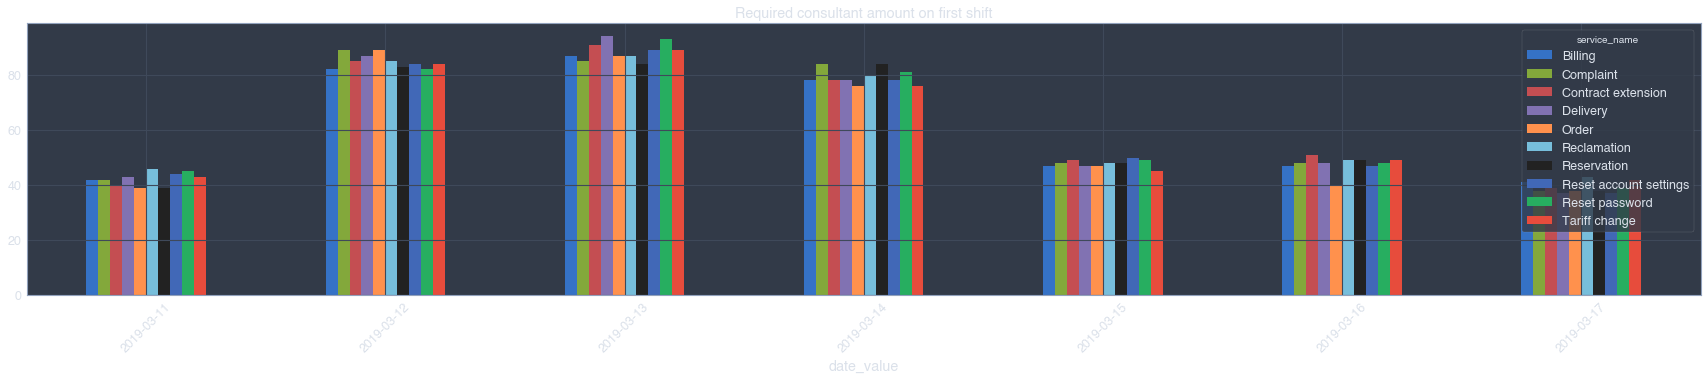

In [24]:
df[(df["shift"] == "1")].groupby(["date_value", "service_name"])["required_consultant_amount"] \
    .sum() \
        .unstack() \
            .plot \
                .bar(rot = 45, title = "Required consultant amount on first shift", figsize = (30, 5), legend = True)
plt.show()

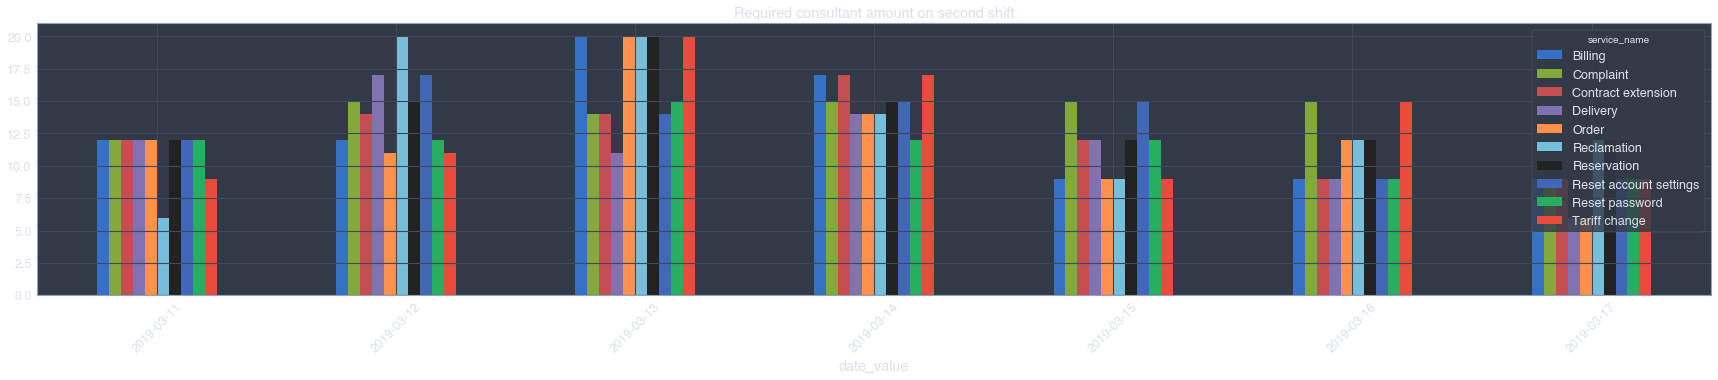

In [25]:
df[(df["shift"] == "2")].groupby(["date_value", "service_name"])["required_consultant_amount"] \
    .sum() \
        .unstack() \
            .plot \
                .bar(rot = 45, title = "Required consultant amount on second shift", figsize = (30, 5), legend = True)
plt.show()

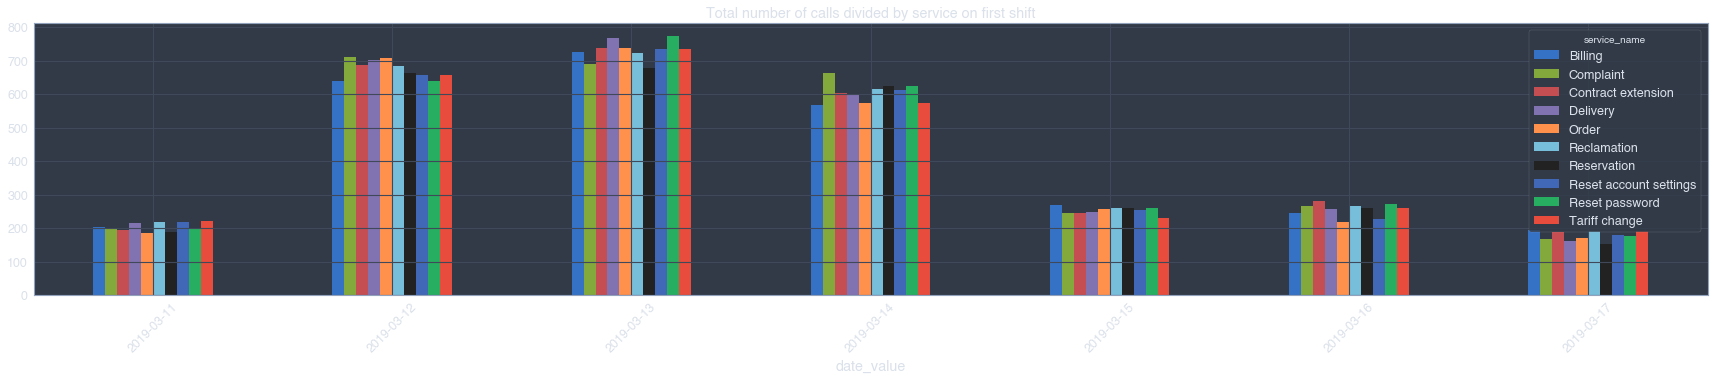

In [26]:
df[(df["shift"] == "1")].groupby(["date_value", "service_name"])["total_call"] \
    .sum() \
        .unstack() \
            .plot \
                .bar(rot = 45, title = "Total number of calls divided by service on first shift", figsize = (30, 5), legend = True)
plt.show()

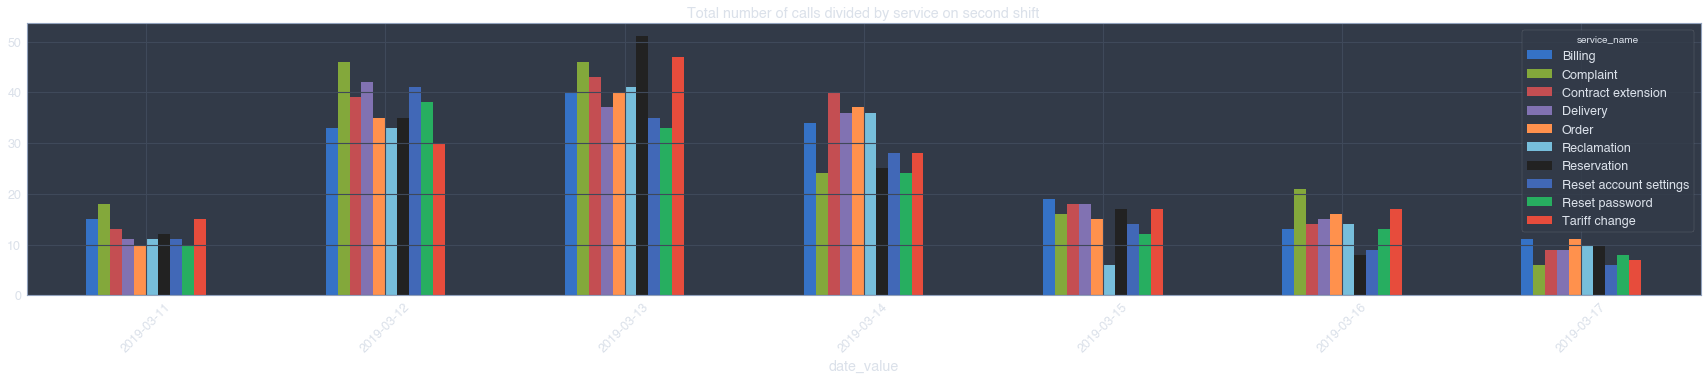

In [28]:
df[(df["shift"] == "2")].groupby(["date_value", "service_name"])["total_call"] \
    .sum() \
        .unstack() \
            .plot \
                .bar(rot = 45, title = "Total number of calls divided by service on second shift", figsize = (30, 5), legend = True)
plt.show()

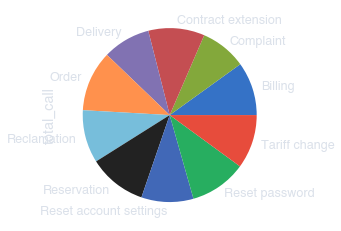

In [65]:
df[(df["date_key"] == 20190304)].groupby(["service_name"])["total_call"].sum().plot.pie()
plt.show()